based on:
https://www.kaggle.com/code/amirmohammadparvizi/google-smartphone-decimeter-challenge-2023

In [ ]:
pip install pymap3d
pip install folium matplotlib mapclassify

In [176]:
import pandas as pd
import pymap3d as pm
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString

import torch
import torch.nn as nn
pd.options.display.max_columns = 100

In [5]:
# smartphone-decimeter-2023/sdc2023/train/2023-09-07-22-48-us-ca-routebc2/pixel4xl

In [6]:
# Read data
gnss_df = pd.read_csv(f'/content/device_gnss.csv')  # GNSS data
gt_df = pd.read_csv(f'/content/ground_truth.csv')  # ground truth

In [103]:
gnss_df

,MessageType,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,Svid,TimeOffsetNanos,State,ReceivedSvTimeNanos,ReceivedSvTimeUncertaintyNanos,Cn0DbHz,PseudorangeRateMetersPerSecond,PseudorangeRateUncertaintyMetersPerSecond,AccumulatedDeltaRangeState,AccumulatedDeltaRangeMeters,AccumulatedDeltaRangeUncertaintyMeters,CarrierFrequencyHz,CarrierCycles,CarrierPhase,CarrierPhaseUncertainty,MultipathIndicator,SnrInDb,ConstellationType,AgcDb,BasebandCn0DbHz,FullInterSignalBiasNanos,FullInterSignalBiasUncertaintyNanos,SatelliteInterSignalBiasNanos,SatelliteInterSignalBiasUncertaintyNanos,CodeType,ChipsetElapsedRealtimeNanos,ArrivalTimeNanosSinceGpsEpoch,RawPseudorangeMeters,RawPseudorangeUncertaintyMeters,SignalType,ReceivedSvTimeNanosSinceGpsEpoch,SvPositionXEcefMeters,SvPositionYEcefMeters,SvPositionZEcefMeters,SvElevationDegrees,SvAzimuthDegrees,SvVelocityXEcefMetersPerSecond,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond,IsrbMeters,IonosphericDelayMeters,TroposphericDelayMeters,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters
0,Raw,1694126880443,610986000000,18,NaN,-1378161487457706956,0.537306,20.889896,7.913780,10.398900,2,3,0.0,16399,427698373801821,9,38.5,-360.269867,0.0396,25,-89026.092383,0.001332,1575420000,NaN,NaN,NaN,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,576334648594,1.378162e+18,2.095703e+07,2.698132,GPS_L1_CA,1.378162e+18,-1.322935e+07,-7.603134e+06,2.160578e+07,56.459543,321.364906,590.981237,-2707.692420,-576.228822,-44148.525049,0.005620,0.000000,5.871727,2.996813,-2.681241e+06,-4.308190e+06,3.851104e+06
1,Raw,1694126880443,610986000000,18,NaN,-1378161487457706956,0.537306,20.889896,7.913780,10.398900,2,4,0.0,16399,427698368736549,10,38.2,-398.478210,0.0176,25,-96934.561896,0.001522,1575420000,NaN,NaN,NaN,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,576334648594,1.378162e+18,2.247556e+07,2.997925,GPS_L1_CA,1.378162e+18,-2.330676e+07,-2.260355e+06,1.265781e+07,34.097799,274.419271,1474.012713,-660.418634,2585.884728,44772.817659,0.003594,0.000000,8.554520,4.448268,-2.681241e+06,-4.308190e+06,3.851104e+06
2,Raw,1694126880443,610986000000,18,NaN,-1378161487457706956,0.537306,20.889896,7.913780,10.398900,2,9,0.0,16399,427698360265816,12,36.1,-519.215820,0.0066,25,-125742.447632,0.001808,1575420000,NaN,NaN,NaN,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,576334648594,1.378162e+18,2.501502e+07,3.597509,GPS_L1_CA,1.378162e+18,-2.552961e+07,5.803687e+06,4.532469e+06,7.320897,266.355159,453.990666,-466.912807,3094.035187,-19726.962987,0.003075,0.000000,15.809315,18.608349,-2.681241e+06,-4.308190e+06,3.851104e+06
3,Raw,1694126880443,610986000000,18,NaN,-1378161487457706956,0.537306,20.889896,7.913780,10.398900,2,16,0.0,16399,427698360548414,53,23.3,-630.290710,0.9135,16,0.000000,0.000000,1575420000,NaN,NaN,NaN,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,576334648594,1.378162e+18,2.493030e+07,15.889000,GPS_L1_CA,1.378162e+18,-8.924642e+05,-2.402807e+07,-1.106962e+07,8.101297,150.897550,641.484819,-1244.094672,2768.809759,-137115.496701,0.001296,0.000000,16.512906,16.982277,-2.681241e+06,-4.308190e+06,3.851104e+06
4,Raw,1694126880443,610986000000,18,NaN,-1378161487457706956,0.537306,20.889896,7.913780,10.398900,2,21,0.0,16399,427698367025421,27,28.4,500.101288,0.6120,16,0.000000,0.000000,1575420000,NaN,NaN,NaN,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,576334648594,1.378162e+18,2.298855e+07,8.094396,GPS_L1_CA,1.378162e+18,-2.039893e+07,-1.745984e+07,-2.755801e+06,32.277616,204.556675,446.854058,76.503304,-3094.884036,44788.926639,0.001398,0.000000,9.417800,4.668302,-2.681241e+06,-4.308190e+06,3.851104e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78221,Raw,1694128

In [104]:
gnss_df.columns

Index(['MessageType', 'utcTimeMillis', 'TimeNanos', 'LeapSecond',
       'TimeUncertaintyNanos', 'FullBiasNanos', 'BiasNanos',
       'BiasUncertaintyNanos', 'DriftNanosPerSecond',
       'DriftUncertaintyNanosPerSecond', 'HardwareClockDiscontinuityCount',
       'Svid', 'TimeOffsetNanos', 'State', 'ReceivedSvTimeNanos',
       'ReceivedSvTimeUncertaintyNanos', 'Cn0DbHz',
       'PseudorangeRateMetersPerSecond',
       'PseudorangeRateUncertaintyMetersPerSecond',
       'AccumulatedDeltaRangeState', 'AccumulatedDeltaRangeMeters',
       'AccumulatedDeltaRangeUncertaintyMeters', 'CarrierFrequencyHz',
       'CarrierCycles', 'CarrierPhase', 'CarrierPhaseUncertainty',
       'MultipathIndicator', 'SnrInDb', 'ConstellationType', 'AgcDb',
       'BasebandCn0DbHz', 'FullInterSignalBiasNanos',
       'FullInterSignalBiasUncertaintyNanos', 'SatelliteInterSignalBiasNanos',
       'SatelliteInterSignalBiasUncertaintyNanos', 'CodeType',
       'ChipsetElapsedRealtimeNanos', 'ArrivalTimeNanosSince

In [191]:
columns_keep = ['TimeNanos', 'LeapSecond', 'FullBiasNanos', 'BiasNanos',
       'BiasUncertaintyNanos', 'DriftNanosPerSecond',
       'DriftUncertaintyNanosPerSecond', 'TimeOffsetNanos', 'ReceivedSvTimeNanos',
       'ReceivedSvTimeUncertaintyNanos', 'Cn0DbHz',
       'PseudorangeRateMetersPerSecond',
       'PseudorangeRateUncertaintyMetersPerSecond',
       'AccumulatedDeltaRangeState', 'AccumulatedDeltaRangeMeters',
       'AccumulatedDeltaRangeUncertaintyMeters', 'CarrierFrequencyHz',
       'ChipsetElapsedRealtimeNanos', 'ArrivalTimeNanosSinceGpsEpoch',
       'RawPseudorangeMeters', 'RawPseudorangeUncertaintyMeters',
       'ReceivedSvTimeNanosSinceGpsEpoch', 'SvPositionXEcefMeters',
       'SvPositionYEcefMeters', 'SvPositionZEcefMeters', 'SvElevationDegrees',
       'SvAzimuthDegrees', 'SvVelocityXEcefMetersPerSecond',
       'SvVelocityYEcefMetersPerSecond', 'SvVelocityZEcefMetersPerSecond',
       'SvClockBiasMeters', 'SvClockDriftMetersPerSecond', 'IsrbMeters',
       'IonosphericDelayMeters', 'TroposphericDelayMeters',
       'WlsPositionXEcefMeters', 'WlsPositionYEcefMeters',
       'WlsPositionZEcefMeters']

In [271]:

X_df = gnss_df.groupby('TimeNanos')[columns_keep].mean()

In [272]:
X_df

,TimeNanos,LeapSecond,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,TimeOffsetNanos,ReceivedSvTimeNanos,ReceivedSvTimeUncertaintyNanos,Cn0DbHz,PseudorangeRateMetersPerSecond,PseudorangeRateUncertaintyMetersPerSecond,AccumulatedDeltaRangeState,AccumulatedDeltaRangeMeters,AccumulatedDeltaRangeUncertaintyMeters,CarrierFrequencyHz,ChipsetElapsedRealtimeNanos,ArrivalTimeNanosSinceGpsEpoch,RawPseudorangeMeters,RawPseudorangeUncertaintyMeters,ReceivedSvTimeNanosSinceGpsEpoch,SvPositionXEcefMeters,SvPositionYEcefMeters,SvPositionZEcefMeters,SvElevationDegrees,SvAzimuthDegrees,SvVelocityXEcefMetersPerSecond,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond,IsrbMeters,IonosphericDelayMeters,TroposphericDelayMeters,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters
TimeNanos,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
610986000000,6.109860e+11,18.0,-1.378161e+18,0.537306,20.889896,7.913780,10.398900,0.0,3.520951e+14,15.333333,32.174359,-20.334120,0.327126,22.923077,-5893.111435,0.057595,1.467805e+09,5.763346e+11,1.378162e+18,2.459156e+07,4.596818,1.378162e+18,-6.457120e+06,-8.771425e+06,1.233143e+07,26.071334,190.068182,354.797263,-158.693859,202.030732,-43958.730213,0.001248,-520.270631,12.647346,10.386435,-2.681241e+06,-4.308190e+06,3.851104e+06
611986000000,6.119860e+11,18.0,-1.378161e+18,0.163155,21.635813,1.404144,11.018952,0.0,3.455105e+14,14.804878,32.941463,-41.712301,0.340363,22.804878,1500.373863,0.041199,1.463944e+09,5.773346e+11,1.378162e+18,2.459154e+07,3.928050,1.378162e+18,-6.456765e+06,-8.771584e+06,1.233163e+07,26.071614,190.067143,354.863255,-158.624406,201.795615,-43958.728965,0.001248,-518.449734,12.647040,10.385404,-2.681240e+06,-4.308185e+06,3.851099e+06
612986000000,6.129860e+11,18.0,-1.378161e+18,0.255806,20.543996,1.018447,10.418717,0.0,3.480105e+14,13.324324,34.013514,-34.361002,0.170197,23.621622,-6435.120459,0.043984,1.483554e+09,5.783346e+11,1.378162e+18,2.449375e+07,3.994532,1.378162e+18,-7.700568e+06,-8.956420e+06,1.182188e+07,27.077388,198.165868,397.680009,-300.307545,162.991024,-46210.144362,0.001578,-421.393025,12.296712,9.788826,-2.681240e+06,-4.308185e+06,3.851100e+06
613986000000,6.139860e+11,18.0,-1.378161e+18,0.616678,20.984313,0.499344,10.418845,0.0,3.574984e+14,12.833333,32.576190,-32.403766,0.412748,22.714286,-3014.147912,0.046871,1.446994e+09,5.793346e+11,1.378162e+18,2.454899e+07,3.769890,1.378162e+18,-6.201464e+06,-9.205026e+06,1.203543e+07,26.062609,188.437995,355.834724,-151.387173,274.638278,-41139.230899,0.001186,-563.955765,12.792244,10.267333,-2.681240e+06,-4.308186e+06,3.851099e+06
614986000000,6.149860e+11,18.0,-1.378161e+18,0.245771,20.294019,-0.219097,10.411290,0.0,3.501096e+14,13.763158,33.736842,-29.844222,0.189705,23.736842,-10335.073788,0.042244,1.475472e+09,5.803346e+11,1.378162e+18,2.458308e+07,4.126091,1.378162e+18,-7.038592e+06,-8.920326e+06,1.210836e+07,26.649528,194.096220,375.425213,-233.542840,186.993309,-48796.155230,0.001294,-471.109892,12.481474,9.871030,-2.681239e+06,-4.308187e+06,3.851100e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675986000000,2.675986e+12,18.0,-1.378161e+18,0.209557,26.221864,-1.595839,10.553281,0.0,3.433597e+14,14.871795,31.933333,-82.290596,0.191662,24.205128,-23145.860850,0.057014,1.458069e+09,2.641335e+12,1.378164e+18,2.394573e+07,4.458452,1.378164e+18,-8.547057e+06,-9.194299e+06,1.317687e+07,31.476580,200.213408,333.099363,-283.564093,414.391669,-33083.091711,0.001416,-541.835508,11.359278,7.402466,-2.681240e+06,-4.308183e+06,3.851096e+06
2676986000000,2.676986e+12,18.0,-1.378161e+18,0.742453,26.427302,-3.404066,10.565629,0.0,3.433607e+14,15.076923,31.933333,-78.570147,0.216269,24.717949,-16987.155023,0.057013,1.458069e+09,2.642335e+12,1.378164e+18,2.386908e+07,4.519948,1.378164e+18,-8.610360e+06,-9.145438e+06

In [273]:
# X_df[['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']] = X_df[['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']].apply(lambda p: pd.Series(pm.ecef2geodetic(p[0], p[1],p[2]), index=['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']), axis=1)

In [274]:
X_df

,TimeNanos,LeapSecond,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,TimeOffsetNanos,ReceivedSvTimeNanos,ReceivedSvTimeUncertaintyNanos,Cn0DbHz,PseudorangeRateMetersPerSecond,PseudorangeRateUncertaintyMetersPerSecond,AccumulatedDeltaRangeState,AccumulatedDeltaRangeMeters,AccumulatedDeltaRangeUncertaintyMeters,CarrierFrequencyHz,ChipsetElapsedRealtimeNanos,ArrivalTimeNanosSinceGpsEpoch,RawPseudorangeMeters,RawPseudorangeUncertaintyMeters,ReceivedSvTimeNanosSinceGpsEpoch,SvPositionXEcefMeters,SvPositionYEcefMeters,SvPositionZEcefMeters,SvElevationDegrees,SvAzimuthDegrees,SvVelocityXEcefMetersPerSecond,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond,IsrbMeters,IonosphericDelayMeters,TroposphericDelayMeters,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters
TimeNanos,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
610986000000,6.109860e+11,18.0,-1.378161e+18,0.537306,20.889896,7.913780,10.398900,0.0,3.520951e+14,15.333333,32.174359,-20.334120,0.327126,22.923077,-5893.111435,0.057595,1.467805e+09,5.763346e+11,1.378162e+18,2.459156e+07,4.596818,1.378162e+18,-6.457120e+06,-8.771425e+06,1.233143e+07,26.071334,190.068182,354.797263,-158.693859,202.030732,-43958.730213,0.001248,-520.270631,12.647346,10.386435,-2.681241e+06,-4.308190e+06,3.851104e+06
611986000000,6.119860e+11,18.0,-1.378161e+18,0.163155,21.635813,1.404144,11.018952,0.0,3.455105e+14,14.804878,32.941463,-41.712301,0.340363,22.804878,1500.373863,0.041199,1.463944e+09,5.773346e+11,1.378162e+18,2.459154e+07,3.928050,1.378162e+18,-6.456765e+06,-8.771584e+06,1.233163e+07,26.071614,190.067143,354.863255,-158.624406,201.795615,-43958.728965,0.001248,-518.449734,12.647040,10.385404,-2.681240e+06,-4.308185e+06,3.851099e+06
612986000000,6.129860e+11,18.0,-1.378161e+18,0.255806,20.543996,1.018447,10.418717,0.0,3.480105e+14,13.324324,34.013514,-34.361002,0.170197,23.621622,-6435.120459,0.043984,1.483554e+09,5.783346e+11,1.378162e+18,2.449375e+07,3.994532,1.378162e+18,-7.700568e+06,-8.956420e+06,1.182188e+07,27.077388,198.165868,397.680009,-300.307545,162.991024,-46210.144362,0.001578,-421.393025,12.296712,9.788826,-2.681240e+06,-4.308185e+06,3.851100e+06
613986000000,6.139860e+11,18.0,-1.378161e+18,0.616678,20.984313,0.499344,10.418845,0.0,3.574984e+14,12.833333,32.576190,-32.403766,0.412748,22.714286,-3014.147912,0.046871,1.446994e+09,5.793346e+11,1.378162e+18,2.454899e+07,3.769890,1.378162e+18,-6.201464e+06,-9.205026e+06,1.203543e+07,26.062609,188.437995,355.834724,-151.387173,274.638278,-41139.230899,0.001186,-563.955765,12.792244,10.267333,-2.681240e+06,-4.308186e+06,3.851099e+06
614986000000,6.149860e+11,18.0,-1.378161e+18,0.245771,20.294019,-0.219097,10.411290,0.0,3.501096e+14,13.763158,33.736842,-29.844222,0.189705,23.736842,-10335.073788,0.042244,1.475472e+09,5.803346e+11,1.378162e+18,2.458308e+07,4.126091,1.378162e+18,-7.038592e+06,-8.920326e+06,1.210836e+07,26.649528,194.096220,375.425213,-233.542840,186.993309,-48796.155230,0.001294,-471.109892,12.481474,9.871030,-2.681239e+06,-4.308187e+06,3.851100e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675986000000,2.675986e+12,18.0,-1.378161e+18,0.209557,26.221864,-1.595839,10.553281,0.0,3.433597e+14,14.871795,31.933333,-82.290596,0.191662,24.205128,-23145.860850,0.057014,1.458069e+09,2.641335e+12,1.378164e+18,2.394573e+07,4.458452,1.378164e+18,-8.547057e+06,-9.194299e+06,1.317687e+07,31.476580,200.213408,333.099363,-283.564093,414.391669,-33083.091711,0.001416,-541.835508,11.359278,7.402466,-2.681240e+06,-4.308183e+06,3.851096e+06
2676986000000,2.676986e+12,18.0,-1.378161e+18,0.742453,26.427302,-3.404066,10.565629,0.0,3.433607e+14,15.076923,31.933333,-78.570147,0.216269,24.717949,-16987.155023,0.057013,1.458069e+09,2.642335e+12,1.378164e+18,2.386908e+07,4.519948,1.378164e+18,-8.610360e+06,-9.145438e+06

In [275]:
X = X_df.values

In [276]:
X.shape

(2070, 38)

In [277]:
# Ground truth
llh_gt_lat = gt_df[['LatitudeDegrees']].to_numpy()
llh_gt_long = gt_df[['LongitudeDegrees']].to_numpy()

In [278]:
X = torch.tensor(X, dtype=torch.float)
llh_gt_lat = torch.tensor(llh_gt_lat, dtype=torch.float)
llh_gt_long = torch.tensor(llh_gt_long, dtype=torch.float)

In [279]:
llh_gt_lat.shape

torch.Size([2070, 1])

In [280]:
class TabularModel(nn.Module):

    def __init__(self, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_in = n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self,  x_cont):

        x = self.layers(torch.cat([self.bn_cont(x_cont)],1))
        return x

In [281]:
model1 = TabularModel(X.shape[1], 1, [500, 250], p=0.4)
model2 = TabularModel(X.shape[1], 1, [750, 500, 100], p=0.4)

In [282]:
model1

TabularModel(
  (bn_cont): BatchNorm1d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=38, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=250, out_features=1, bias=True)
  )
)

In [283]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [284]:
batch_size = 2070
test_size = int(batch_size * .2)

train = X[:batch_size-test_size]
test = X[batch_size-test_size:batch_size]
y_train_lat = llh_gt_lat[:batch_size-test_size]
y_test_lat =llh_gt_lat[batch_size-test_size:batch_size]
y_train_long = llh_gt_long[:batch_size-test_size]
y_test_long =llh_gt_long[batch_size-test_size:batch_size]

In [285]:
train.shape

torch.Size([1656, 38])

In [286]:
test.shape

torch.Size([414, 38])

In [287]:
y_train_lat.shape

torch.Size([1656, 1])

In [288]:
import time
start_time = time.time()

epochs = 1000
losses1 = []

for i in range(epochs):
    i+=1
    y_pred = model1(train)
    loss = torch.sqrt(criterion(y_pred, y_train_lat)) # RMSE
    losses1.append(loss)

    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 37.40220642
epoch:  26  loss: 37.09681702
epoch:  51  loss: 36.47181702
epoch:  76  loss: 35.20141983
epoch: 101  loss: 33.13603592
epoch: 126  loss: 30.17510605
epoch: 151  loss: 26.27396774
epoch: 176  loss: 21.64543533
epoch: 201  loss: 16.19562721
epoch: 226  loss: 10.44548798
epoch: 251  loss: 5.68023205
epoch: 276  loss: 5.48506546
epoch: 301  loss: 4.76607132
epoch: 326  loss: 4.33608246
epoch: 351  loss: 4.37807035
epoch: 376  loss: 4.09862375
epoch: 401  loss: 3.95468998
epoch: 426  loss: 3.82097578
epoch: 451  loss: 3.79978919
epoch: 476  loss: 3.84979916
epoch: 501  loss: 3.43247962
epoch: 526  loss: 3.53488779
epoch: 551  loss: 3.36806107
epoch: 576  loss: 3.22543263
epoch: 601  loss: 3.25843716
epoch: 626  loss: 3.12559080
epoch: 651  loss: 3.16205168
epoch: 676  loss: 3.12009931
epoch: 701  loss: 3.09961700
epoch: 726  loss: 2.93122387
epoch: 750  loss: 2.81283426

Duration: 31 seconds


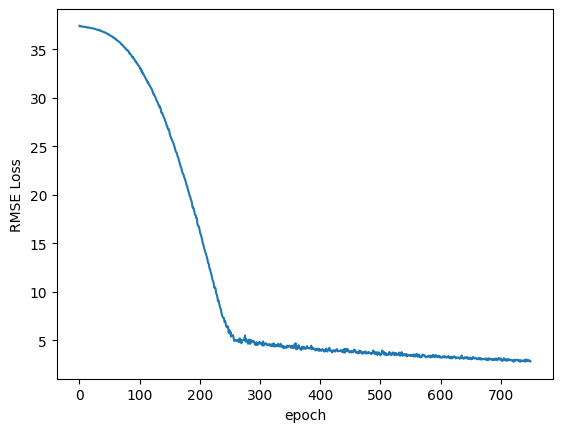

In [289]:
plt.plot(range(epochs), [loss.detach().numpy() for loss in losses1])
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [290]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [291]:
import time
start_time = time.time()

epochs = 1000
losses2 = []

for i in range(epochs):
    i+=1
    y_pred = model2(train)
    loss = torch.sqrt(criterion(y_pred, y_train_long)) # RMSE
    losses2.append(loss)

    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 121.97780609
epoch:  26  loss: 121.80182648
epoch:  51  loss: 121.48886871
epoch:  76  loss: 120.87565613
epoch: 101  loss: 120.05387878
epoch: 126  loss: 118.73375702
epoch: 151  loss: 117.18946838
epoch: 176  loss: 115.24105072
epoch: 201  loss: 113.14847565
epoch: 226  loss: 110.36962891
epoch: 251  loss: 107.49978638
epoch: 276  loss: 104.10146332
epoch: 301  loss: 100.31279755
epoch: 326  loss: 96.38116455
epoch: 351  loss: 92.05081177
epoch: 376  loss: 87.24330902
epoch: 401  loss: 82.55121613
epoch: 426  loss: 77.05401611
epoch: 451  loss: 71.39124298
epoch: 476  loss: 65.77069092
epoch: 501  loss: 59.66304398
epoch: 526  loss: 52.77136993
epoch: 551  loss: 46.18947601
epoch: 576  loss: 39.60690689
epoch: 601  loss: 32.70154572
epoch: 626  loss: 25.69757271
epoch: 651  loss: 19.92369461
epoch: 676  loss: 14.75681686
epoch: 701  loss: 11.95133781
epoch: 726  loss: 11.40415382
epoch: 751  loss: 11.33864117
epoch: 776  loss: 10.99233913
epoch: 801  loss: 10.795492

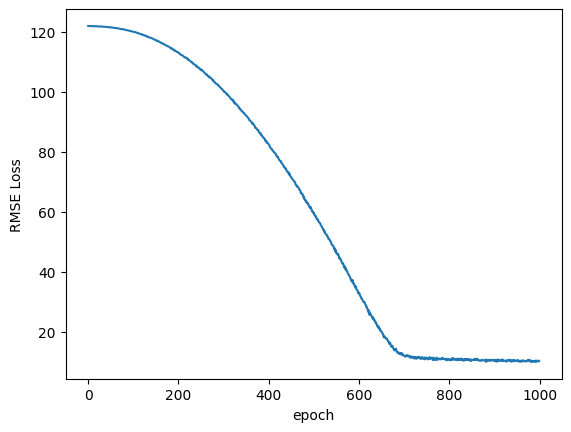

In [293]:
plt.plot(range(epochs), [loss.detach().numpy() for loss in losses2])
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [294]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val_lat = model1(test)
    loss = torch.sqrt(criterion(y_val_lat, y_test_lat))
print(f'RMSE: {loss:.8f}')

RMSE: 2.89193654


In [295]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val_long = model2(test)
    loss = torch.sqrt(criterion(y_val_long, y_test_long))
print(f'RMSE: {loss:.8f}')

RMSE: 10.45495319


In [296]:
y_val_long.shape

torch.Size([414, 1])

In [297]:
long_pred = y_val_long.reshape(-1).detach().numpy()
lat_pred = y_val_lat.reshape(-1).detach().numpy()
long_test = y_test_long.reshape(-1).detach().numpy()
lat_test = y_test_lat.reshape(-1).detach().numpy()


In [298]:
geometry_predicted = gpd.points_from_xy(long_pred, lat_pred)
geometry_test = gpd.points_from_xy(long_test, lat_test)


In [299]:
list_of_lines = []
for item in list(zip(geometry_predicted.tolist(), geometry_test.tolist())):
  line = LineString(item)
  list_of_lines.append(line)

In [300]:
error_lines = gpd.GeoDataFrame(geometry=list_of_lines, crs=4326)

In [301]:
gdf_predicted = gpd.GeoDataFrame(geometry=geometry_predicted, crs=4326)
gdf_test = gpd.GeoDataFrame(geometry=geometry_test, crs=4326)

In [302]:
m = error_lines.explore()
m1 = gdf_test.explore(m = m)
m2 = gdf_predicted.explore(m = m1)

In [303]:
m2

In [310]:
error_lines_3857 = error_lines.to_crs(3857)

In [314]:
error_lines['geometry'].length

<ipython-input-314-ff97701ba92b>:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  error_lines['geometry'].length


0      21.429824
1       5.251320
2      11.597843
3      21.771740
4       9.084537
         ...    
409     9.013218
410     2.493035
411     2.926466
412    14.760474
413     1.409982
Length: 414, dtype: float64

In [322]:
predicted_vs_groud_truth = pd.DataFrame({'predicted': gdf_predicted['geometry'].to_wkt(), 'GT': gdf_test['geometry'].to_wkt(), 'error in degrees': error_lines['geometry'].length})

<ipython-input-322-39234b5156b9>:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  predicted_vs_groud_truth = pd.DataFrame({'predicted': gdf_predicted['geometry'].to_wkt(), 'GT': gdf_test['geometry'].to_wkt(), 'error in degrees': error_lines['geometry'].length})


In [323]:
predicted_vs_groud_truth

,predicted,GT,error in degrees
0,POINT (-143.33107 37.81332),POINT (-121.905556 37.383553),21.429824
1,POINT (-126.965172 35.977379),POINT (-121.905594 37.38345),5.251320
2,POINT (-133.480377 36.651752),POINT (-121.905632 37.383347),11.597843
3,POINT (-143.573105 39.511845),POINT (-121.90567 37.383247),21.771740
4,POINT (-130.959488 36.636234),POINT (-121.905708 37.383148),9.084537
...,...,...,...
409,POINT (-112.939804 36.373146),POINT (-121.896461 37.381306),9.013218
410,POINT (-119.404213 37.443916),POINT (-121.896461 37.381306),2.493035
411,POINT (-119.035637 37.997654),POINT (-121.896461 37.381306),2.926466
412,POINT (-107.969475 32.491455),POINT (-121.896461 37.381306),14.760474
